<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/S9%20-%20Assignment%20QnA/Backup/S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# GPU Check

In [3]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



# Ablumentations library


In [4]:
# Import dependencies
!!pip install --upgrade albumentations
!pip install torchscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import random
import matplotlib.pyplot as plt

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
batchsize = 512

In [8]:
def data_param ():
    cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    data = cifar_trainset.data / 255 # data is numpy array
    mean = data.mean(axis = (0,1,2))
    std = data.std(axis = (0,1,2))
    return mean, std

### implement (RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8))



In [9]:
def train_transform_func(mean, std):
    train_transform = A.Compose(
      [
      A.Normalize(mean=mean, std=std),
      ToTensorV2(),
      ]
    )
    return lambda img:train_transform(image=np.array(img))["image"]

In [10]:
def test_transform_func(mean, std):
    test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)
                                        ])
    return test_transform

In [11]:
mean, std = data_param()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_func(mean, std))
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_func(mean, std))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
def split_data_set(trainset, testset, cuda = torch.cuda.is_available(), batch_size=256):
    # dataloader arguments - something you'll fetch these from cmdprmt
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

    # train dataloader
    trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

    # test dataloader
    testloader = torch.utils.data.DataLoader(testset, **dataloader_args)
    return trainloader, testloader

In [13]:
trainloader, testloader = split_data_set(trainset, testset)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Neural Network



In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      # Convolution 1 e.g. 32x32x3 | 3x3x3x16  
      self.conv1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU()
      ) 

      # Convolution 2 | 3x3x16x32
      self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU()
      )

      # Convolution 3 | 3x3x32x48
      self.conv3 = nn.Sequential(
        nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(48),
        nn.ReLU()
      ) 

      # Apply GAP and get 1x1x48
      self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=32)
      ) # output_size = 1
      
      # FC Layer ultimus 
      self.ultimus_layer = nn.Linear(48, 8,bias=False)
      self.ultimus_rev = nn.Linear(8, 48,bias=False)
     
      # FC layer that converts 48 to 10 
      self.out = nn.Linear(48, 10, bias = True)

    # Ultimus block 
    # Creates 3 FC layers called K, Q and V such that: X*K = 48*48x8 > 8,  X*Q = 48*48x8 > 8, X*V = 48*48x8 > 8 
    # then create AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
    # then Z = V*AM = 8*8 > 8
    # then another FC layer called Out that:
    # Z*Out = 8*8x48 > 48
    def Ultimus (self, input):
      k = self.ultimus_layer(input)
      q = self.ultimus_layer(input)
      v = self.ultimus_layer(input)
      #print (k)
      #create AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
      AM =  F.softmax(torch.div(torch.matmul(torch.transpose(q, 0, 1), k) , pow(8, 0.5)))
      
      # then Z = V*AM = 8*8 > 8
      Z = torch.matmul(v, AM)
      z_out = self.ultimus_rev(Z)
      return z_out
      
     
    def forward(self, x):
      # 3 convolution layers
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)

      # Gap layer 
      x = self.gap(x)
      #print(x.shape)
      x = x.view(x.size(0), -1)
      
      # Repeat Ultimus block 4 times
      x = self.Ultimus(x)  
      x = self.Ultimus(x)  
      x = self.Ultimus(x)  
      x = self.Ultimus(x)      

      #FC layer that converts 48 to 10 
      x = self.out(x)
      return F.softmax(x, dim=-1)#SoftMax

In [15]:
from torchscan import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

cuda
_______________________________________________________________________________
Layer              Type          Output Shape        Param #    Receptive field
net                Net           (-1, 10)            0          1              
├─conv1            Sequential    (-1, 16, 32, 32)    497        3              
├─conv2            Sequential    (-1, 32, 32, 32)    4,737      5              
├─conv3            Sequential    (-1, 48, 32, 32)    14,017     7              
├─gap              Sequential    (-1, 48, 1, 1)      0          38             
├─ultimus_layer    Linear        (-1, 8)             384        38             
├─ultimus_rev      Linear        (-1, 48)            384        38             
├─out              Linear        (-1, 10)            490        38             
Trainable params: 20,314
Non-trainable params: 0
Total params: 20,314
-------------------------------------------------------------------------------
Model size (params + buffers): 0.08 Mb
Framew

<ipython-input-14-6a05fff364e0>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  AM =  F.softmax(torch.div(torch.matmul(torch.transpose(q, 0, 1), k) , pow(8, 0.5)))


3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [16]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

Uses One Cycle Policy such that:
Total Epochs = 24
Max at Epoch = 5
LRMIN = FIND
LRMAX = FIND
NO Annihilation



In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [18]:
#training loops
def train(model, device, train_loader, train_acc, train_loss, optimizer, scheduler, l_rate, criterion):

    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):

        ## Get data samples
        data, target = data.to(device), target.to(device)

        ## Init
        optimizer.zero_grad()

        ## Predict
        y_pred = model(data)

        ## Calculate loss
        loss = criterion(y_pred, target)

        #train_loss.append(loss.data.cpu().numpy().item())
        train_loss.append(loss.item())

        ## Backpropagation
        loss.backward()

        optimizer.step()
        scheduler.step()

        # record and update learning rate
        l_rate.append(get_lr(optimizer))


        ## Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}% learning_rate={l_rate[-1]:0.8f}')
        train_acc.append(100*correct/processed)

In [19]:
# test loop
def test(model, device, test_loader, test_acc, test_losses, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [20]:
def start_training_process(model, device, trainloader, testloader, optimizer='Adam', learning_rate = 0.01, epochs = 20):

    # Hyperparameters
    train_acc, train_losses, test_acc, test_losses, l_rate = [], [], [], [], []
    if optimizer == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, epochs = epochs, steps_per_epoch = len(trainloader), pct_start = 0.2) # pct_start = 0.2 (~5/24) since max_lr is required at Epoch 5

    for epoch in range(epochs):
        print("EPOCH:", epoch + 1)
        train(model, device, trainloader, train_acc, train_losses, optimizer, scheduler, l_rate, criterion)
        test(model, device, testloader, test_acc, test_losses, criterion)


    return train_acc, train_losses, test_acc, test_losses, l_rate

# Uses One Cycle Policy such that:
Total Epochs = 24
Max at Epoch = 5 
LRMIN = FIND
LRMAX = FIND
NO Annihilation

In [21]:
# max LR finder https://github.com/davidtvs/pytorch-lr-finder
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-14-6a05fff364e0>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  AM =  F.softmax(torch.div(torch.matmul(torch.transpose(q, 0, 1), k) , pow(8, 0.5)))


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-01


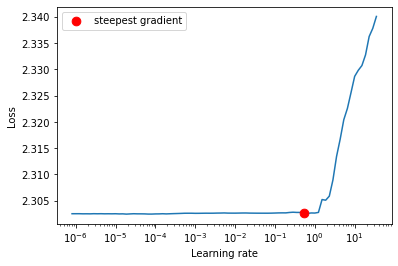

In [22]:
import numpy as np
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [23]:
print ("LR finder:", dir(lr_finder))

LR finder: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_for_scheduler', '_move_to_device', '_set_learning_rate', '_train_batch', '_validate', 'best_loss', 'cache_dir', 'criterion', 'device', 'history', 'memory_cache', 'model', 'model_device', 'optimizer', 'plot', 'range_test', 'reset', 'state_cacher']


LR suggestion: steepest gradient
Suggested LR: 5.34E-01


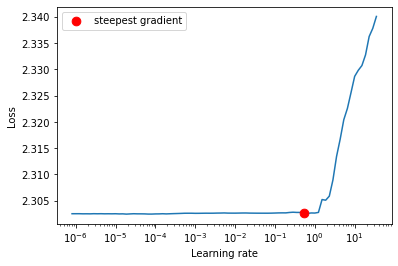

In [24]:
_, lr_suggested = lr_finder.plot()

In [25]:
print ("suggested learning rate: ", lr_suggested)

suggested learning rate:  0.5336699231206313


In [26]:
num_epochs = 24 # change to 20
max_learning_rate = lr_suggested #0.025 # change to 0.01
#print ("here", learning_rate)
train_acc, train_losses, test_acc, test_losses, l_rate = start_training_process(model, device, trainloader, testloader, optimizer = "Adam", learning_rate = max_learning_rate, epochs = num_epochs)

EPOCH: 1


  0%|          | 0/196 [00:00<?, ?it/s]<ipython-input-14-6a05fff364e0>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  AM =  F.softmax(torch.div(torch.matmul(torch.transpose(q, 0, 1), k) , pow(8, 0.5)))
Loss=2.3736507892608643 Batch_id=195 Accuracy=10.76% learning_rate=0.07439038: 100%|██████████| 196/196 [00:12<00:00, 16.12it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=2.38615083694458 Batch_id=195 Accuracy=10.00% learning_rate=0.21155357: 100%|██████████| 196/196 [00:14<00:00, 13.87it/s]



Test set: Average loss: 0.0095, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=2.336150646209717 Batch_id=195 Accuracy=10.00% learning_rate=0.37603138: 100%|██████████| 196/196 [00:13<00:00, 14.78it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=2.38615083694458 Batch_id=195 Accuracy=10.00% learning_rate=0.49970671: 100%|██████████| 196/196 [00:11<00:00, 16.73it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=2.32365083694458 Batch_id=195 Accuracy=10.00% learning_rate=0.53351968: 100%|██████████| 196/196 [00:11<00:00, 16.49it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=2.38615083694458 Batch_id=195 Accuracy=10.00% learning_rate=0.52849924: 100%|██████████| 196/196 [00:11<00:00, 16.61it/s]



Test set: Average loss: 0.0095, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=2.3486506938934326 Batch_id=195 Accuracy=10.00% learning_rate=0.51648890: 100%|██████████| 196/196 [00:11<00:00, 16.86it/s]



Test set: Average loss: 0.0095, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=2.273650646209717 Batch_id=195 Accuracy=10.00% learning_rate=0.49780950: 100%|██████████| 196/196 [00:11<00:00, 16.72it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=2.3111507892608643 Batch_id=195 Accuracy=10.00% learning_rate=0.47296003: 100%|██████████| 196/196 [00:11<00:00, 16.41it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=2.2861506938934326 Batch_id=195 Accuracy=10.00% learning_rate=0.44260430: 100%|██████████| 196/196 [00:11<00:00, 16.85it/s]



Test set: Average loss: 0.0095, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=2.3611507415771484 Batch_id=195 Accuracy=10.00% learning_rate=0.40755321: 100%|██████████| 196/196 [00:12<00:00, 16.10it/s]



Test set: Average loss: 0.0095, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Loss=2.4236507415771484 Batch_id=195 Accuracy=10.00% learning_rate=0.36874310: 100%|██████████| 196/196 [00:11<00:00, 16.84it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Loss=2.38615083694458 Batch_id=195 Accuracy=10.00% learning_rate=0.32721071: 100%|██████████| 196/196 [00:11<00:00, 16.85it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


Loss=2.336150646209717 Batch_id=195 Accuracy=10.00% learning_rate=0.28406551: 100%|██████████| 196/196 [00:10<00:00, 17.89it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Loss=2.336150646209717 Batch_id=195 Accuracy=10.00% learning_rate=0.24046006: 100%|██████████| 196/196 [00:10<00:00, 18.62it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Loss=2.4236507415771484 Batch_id=195 Accuracy=10.00% learning_rate=0.19755919: 100%|██████████| 196/196 [00:11<00:00, 17.41it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 17


Loss=2.3111507892608643 Batch_id=195 Accuracy=10.00% learning_rate=0.15650894: 100%|██████████| 196/196 [00:11<00:00, 16.62it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 18


Loss=2.4111506938934326 Batch_id=195 Accuracy=10.00% learning_rate=0.11840590: 100%|██████████| 196/196 [00:12<00:00, 15.80it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 19


Loss=2.32365083694458 Batch_id=195 Accuracy=10.00% learning_rate=0.08426791: 100%|██████████| 196/196 [00:12<00:00, 16.17it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 20


Loss=2.336150646209717 Batch_id=195 Accuracy=10.00% learning_rate=0.05500693: 100%|██████████| 196/196 [00:12<00:00, 16.30it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 21


Loss=2.3486506938934326 Batch_id=195 Accuracy=10.00% learning_rate=0.03140462: 100%|██████████| 196/196 [00:11<00:00, 16.43it/s]



Test set: Average loss: 0.0095, Accuracy: 1000/10000 (10.00%)

EPOCH: 22


Loss=2.3736507892608643 Batch_id=195 Accuracy=10.00% learning_rate=0.01409146: 100%|██████████| 196/196 [00:11<00:00, 16.38it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 23


Loss=2.3736507892608643 Batch_id=195 Accuracy=10.00% learning_rate=0.00352995: 100%|██████████| 196/196 [00:11<00:00, 16.52it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)

EPOCH: 24


Loss=2.2486507892608643 Batch_id=195 Accuracy=10.00% learning_rate=0.00000223: 100%|██████████| 196/196 [00:11<00:00, 16.67it/s]



Test set: Average loss: 0.0094, Accuracy: 1000/10000 (10.00%)



# Plotting train and test accuracys

Text(0.5, 1.0, 'Test Accuracy')

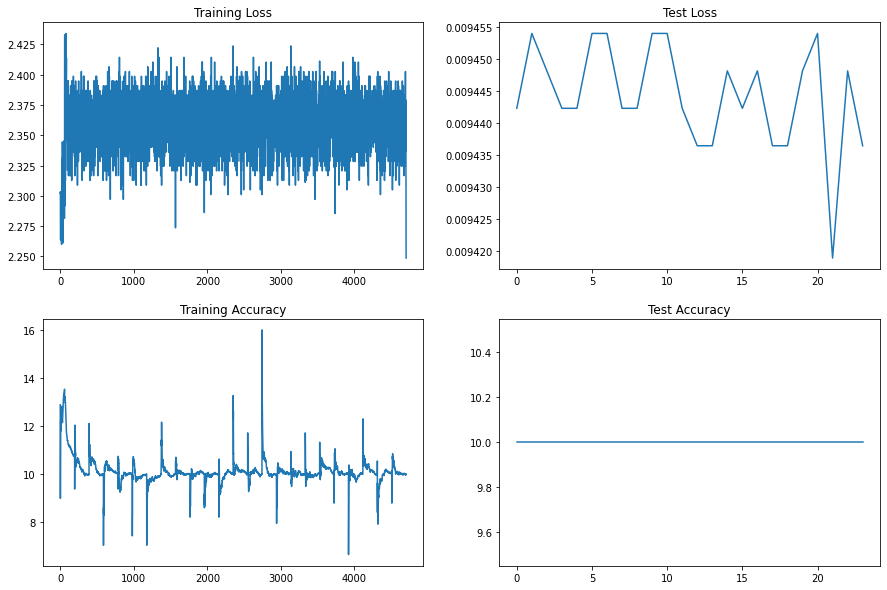

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")